# Quantify Build Pass/Failure

In this notebook, the key perfomance indicators that we would like to create greater visbility into and track over time is the percent of builds that passed/failed. This can be used to capture the build success rate ie. number of successful builds / deployments relative to the total number of builds / deployments. Through this notebook, we will be able to compute:

* Total number of builds
* Total number of passing builds
* Total number of failing builds
* Build pass percentage
* Build failure percentage

_Linked issues: [issue 1](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/114), [issue 2](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/136)_

In [1]:
import gzip
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from ipynb.fs.defs.metric_template import save_to_disk, read_from_disk
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables

METRIC_NAME = "build_pass_failure"

# Specify the path for input grid data,
INPUT_DATA_PATH = "../../../../data/raw/testgrid_183.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "ai4ci/testgrid/metrics")
s3_input_data_path = "raw_data"
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

## Metric Calculation
We find all the tests which are failing i.e have a status code of 12

In [4]:
build_failures_list = testgrid_labelwise_encoding(testgrid_data, 12)

In [5]:
len(build_failures_list)

50999978

In [6]:
build_failures_list[:][6]

(datetime.datetime(2021, 9, 30, 20, 16, 50),
 '"redhat-assisted-installer"',
 'periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted',
 'periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted.Overall',
 None,
 False)

In [7]:
# Convert to dataframe
build_failures_df = pd.DataFrame(
    build_failures_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "build_failure"],
)
build_failures_df = build_failures_df.drop(columns="test_duration")

We use the `Overall` tests as our proxy for builds. We used the labels provided by TestGrid which classify a test overall as Pass or Fail to indicate build success and failures.

In [8]:
build_failures_df = build_failures_df.loc[
    build_failures_df["test"].str.contains("Overall")
]

In [9]:
build_failures_df.head()

,timestamp,tab,grid,test,build_failure
0,2021-10-08 00:18:00,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False
1,2021-10-07 20:37:44,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False
2,2021-10-05 16:04:16,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False
3,2021-10-04 20:36:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False
4,2021-10-04 00:00:45,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False


We now find all the tests which are passing i.e. have a status code of 1.

In [10]:
build_passing_list = testgrid_labelwise_encoding(testgrid_data, 1)

In [11]:
# Convert to dataframe
build_passing_df = pd.DataFrame(
    build_passing_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "build_passing"],
)
build_passing_df = build_passing_df.drop(columns="test_duration")

In [12]:
build_passing_df = build_passing_df.loc[
    build_passing_df["test"].str.contains("Overall")
]

In [13]:
build_passing_df.head()

,timestamp,tab,grid,test,build_passing
0,2021-10-08 00:18:00,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,True
1,2021-10-07 20:37:44,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,True
2,2021-10-05 16:04:16,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,True
3,2021-10-04 20:36:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,True
4,2021-10-04 00:00:45,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False


## Metric Calculation
We want to capture the build pass and build fail percentage.

In [14]:
# Metrics
no_tests = build_passing_df.test.count()
print("Total number of Builds: %i" % (no_tests))
no_failures = build_failures_df.build_failure.sum()
print("Total number of failing builds: %i" % (no_failures))
build_failures_percentage = (
    (build_failures_df.build_failure.sum() / build_failures_df.test.count())
) * 100
print("Build failure percentage: %f" % (build_failures_percentage))
no_pass = build_passing_df.build_passing.sum()
print("Total number of passing builds: %i" % (no_pass))
build_pass_percentage = (
    (build_passing_df.build_passing.sum() / build_passing_df.test.count())
) * 100
print("Build pass percentage: %f" % (build_pass_percentage))

Total number of Builds: 151535
Total number of failing builds: 30906
Build failure percentage: 20.395288
Total number of passing builds: 44918
Build pass percentage: 29.641997


## Visualization
Plot of build success and failure over time

In [15]:
def plot_builds_tab_grid(tab, grid, df):

    """
    Takes in input as tab and grid and plots change in
    build pass/fail over time
    """

    df = df[(df["tab"] == tab) | (df["grid"] == grid)]

    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y="build_status", data=df)
    plt.xlabel("Timestamps")
    plt.ylabel("Build Pass or Fail")
    plt.title("Change in Build Pass or Failure over time")
    plt.show()

In [16]:
combined = pd.merge(
    build_failures_df,
    build_passing_df,
    on=["timestamp", "tab", "grid", "test"],
)

In [17]:
combined

,timestamp,tab,grid,test,build_failure,build_passing
0,2021-10-08 00:18:00,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True
1,2021-10-07 20:37:44,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True
2,2021-10-05 16:04:16,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True
3,2021-10-04 20:36:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True
4,2021-10-04 00:00:45,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,False
...,...,...,...,...,...,...
163072,2021-08-12 03:34:12,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,True,False
163073,2021-08-12 01:55:02,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,True
163074,2021-08-11 01:54:52,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,True,False
163075,2021-08-10 05:03:51,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,True


In [18]:
def label_race(row):
    if row["build_failure"]:
        return "Fail"

    if row["build_passing"]:
        return "Pass"

In [19]:
combined["build_status"] = combined.apply(lambda row: label_race(row), axis=1)

In [20]:
combined.head()

,timestamp,tab,grid,test,build_failure,build_passing,build_status
0,2021-10-08 00:18:00,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
1,2021-10-07 20:37:44,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
2,2021-10-05 16:04:16,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
3,2021-10-04 20:36:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
4,2021-10-04 00:00:45,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,False,None


In [21]:
len(combined)

163077

In [22]:
# since we are only interested in success and failure statuses
combined = combined.dropna()

In [23]:
len(combined)

81148

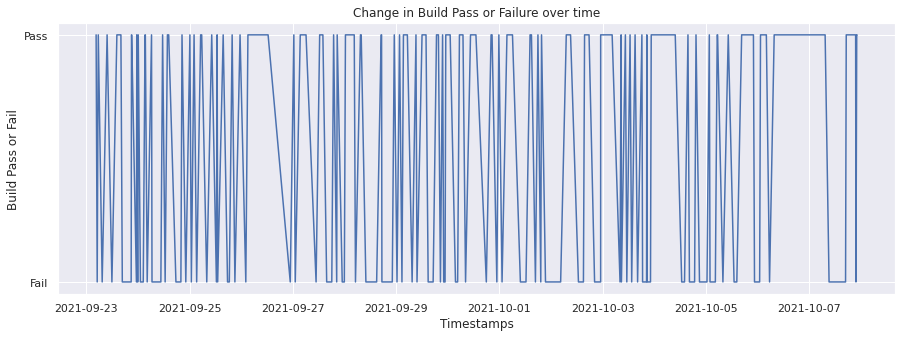

In [24]:
plot_builds_tab_grid(
    "redhat-openshift-informing",
    "release-openshift-okd-installer-e2e-aws-upgrade",
    combined,
)

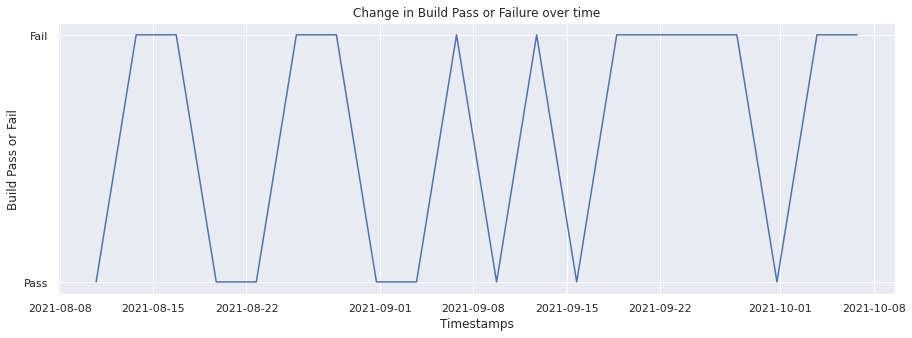

In [25]:
plot_builds_tab_grid(
    "redhat-openshift-ocp-release-4.2-informing",
    "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2",
    combined,
)

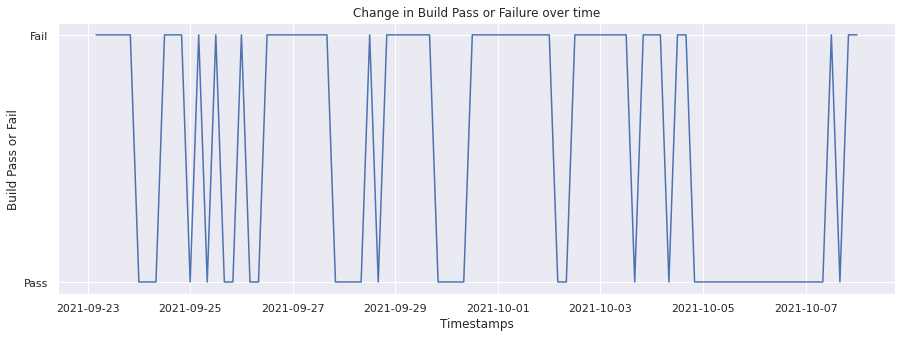

In [26]:
plot_builds_tab_grid("redhat-osde2e-stage-moa", "osde2e-stage-aws-e2e-next-z", combined)

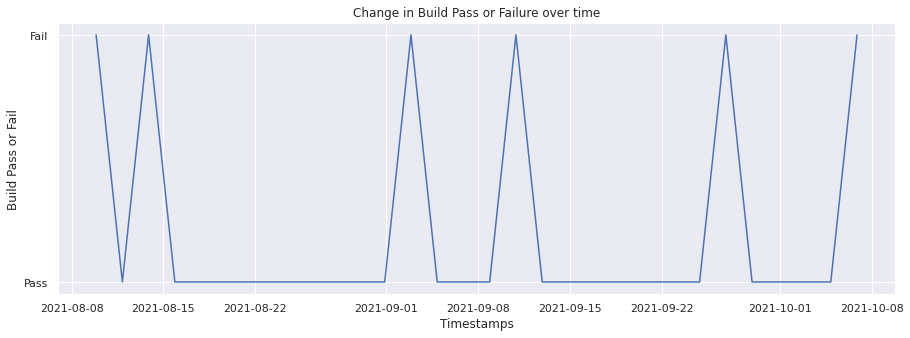

In [27]:
plot_builds_tab_grid(
    "redhat-openshift-ocp-release-4.5-blocking",
    "release-openshift-origin-installer-e2e-gcp-serial-4.5",
    combined,
)

## Save to Ceph or local

In [28]:
timestamp = datetime.datetime.now()

if AUTOMATION:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(
        combined,
        s3_path,
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    save_to_disk(
        combined,
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

In [29]:
## Sanity check to see if the dataset is the same
if AUTOMATION:
    sanity_check = cc.read_from_ceph(
        s3_path,
        f"{METRIC_NAME}/{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )
else:
    sanity_check = read_from_disk(
        OUTPUT_DATA_PATH,
        f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet",
    )

sanity_check

,timestamp,tab,grid,test,build_failure,build_passing,build_status
0,2021-10-08 00:18:00,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
1,2021-10-07 20:37:44,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
2,2021-10-05 16:04:16,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
3,2021-10-04 20:36:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,periodic-ci-openshift-release-master-nightly-4...,False,True,Pass
13,2021-10-04 00:00:45,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,True,Pass
...,...,...,...,...,...,...,...
163072,2021-08-12 03:34:12,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,True,False,Fail
163073,2021-08-12 01:55:02,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,True,Pass
163074,2021-08-11 01:54:52,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,True,False,Fail
163075,2021-08-10 05:03:51,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,True,Pass


### Conclusion

In this Notebook, we use the "Overall" as a proxy for a build. Testgrid refers an aggregate of multiple tests performed at a certain timestamp within a Job as a Build and each build has a unique Build ID. In this notebook, we went ahead and used the labels provided by testgrid which classify a test overall as Pass or Fail to indicate build success and failures and thus calculate the percent of success and failures.